# Introduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

# Color

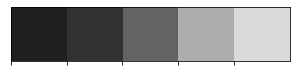

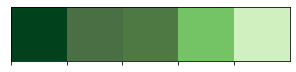

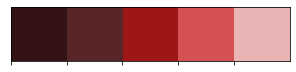

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# Data Preperation

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  inflating: Testing/glioma_t

In [4]:
Xx = []
Yy = []
image_size = 128
for i in labels:
    folderPath = os.path.join(r'/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        Xx.append(img)
        Yy.append(i)
        
for i in labels:
    folderPath = os.path.join(r'/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        Xx.append(img)
        Yy.append(i)
        
Xx = np.array(Xx)
Yy = np.array(Yy)

100%|██████████| 74/74 [00:00<00:00, 130.29it/s]


We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

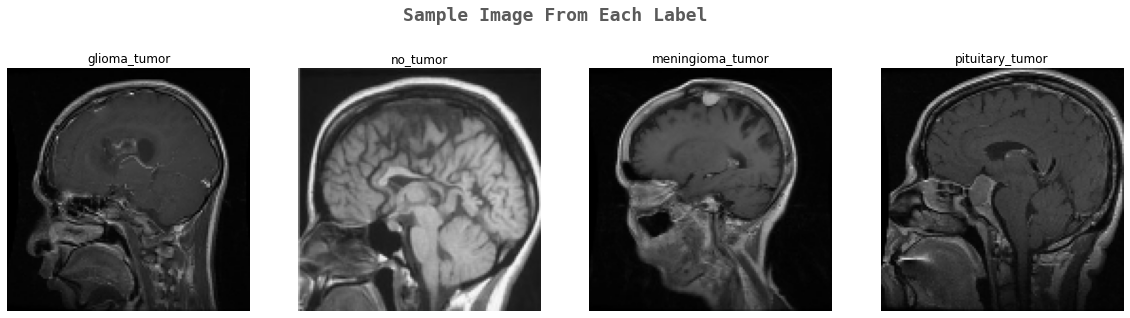

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if Yy[j]==i:
            ax[k].imshow(Xx[j])
            ax[k].set_title(Yy[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
Xx, Yy = shuffle(Xx,Yy, random_state=101)

In [7]:
Xx.shape

(3264, 128, 128, 3)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(Xx)
Xx.shape

(3264, 128, 128, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [9]:
X_train,X_test,y_train,y_test = train_test_split(Xx,Yy, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

In [11]:
from tensorflow.keras.applications import ResNet152V2
resnet = ResNet152V2(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


In [12]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

We finally compile our model.

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet152v1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

In [15]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/15
74/74 [==============================] - ETA: 0s - loss: 0.7883 - accuracy: 0.7114
Epoch 00001: val_accuracy improved from -inf to 0.14796, saving model to resnet152v1.h5
74/74 [==============================] - 84s 802ms/step - loss: 0.7883 - accuracy: 0.7114 - val_loss: 269.8510 - val_accuracy: 0.1480 - lr: 0.0010
Epoch 2/15
74/74 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8536
Epoch 00002: val_accuracy improved from 0.14796 to 0.43707, saving model to resnet152v1.h5
74/74 [==============================] - 56s 756ms/step - loss: 0.4478 - accuracy: 0.8536 - val_loss: 8.3907 - val_accuracy: 0.4371 - lr: 0.0010
Epoch 3/15
74/74 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8923
Epoch 00003: val_accuracy improved from 0.43707 to 0.79592, saving model to resnet152v1.h5
74/74 [==============================] - 56s 758ms/step - loss: 0.3170 - accuracy: 0.8923 - val_loss: 0.7381 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/15


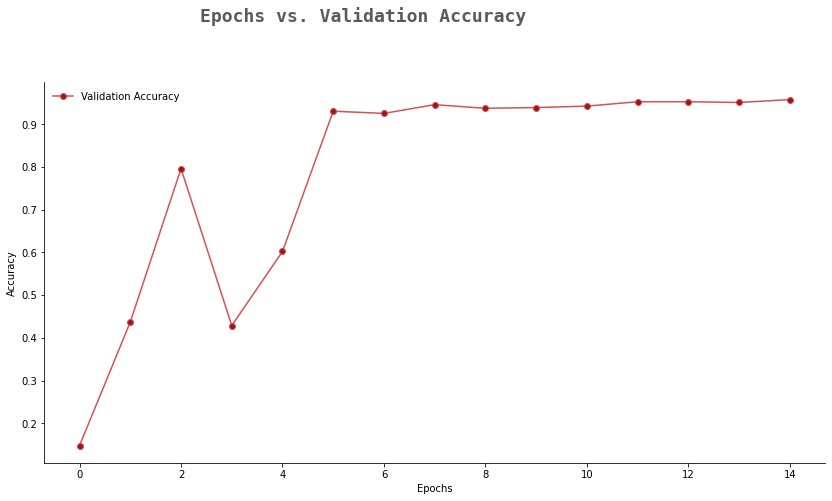

In [16]:
filterwarnings('ignore')

epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,1,figsize=(14,7))
val_acc = history.history['val_accuracy']

fig.text(s='Epochs vs. Validation Accuracy',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()

ax.plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

fig.show()


---

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)

---

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [18]:
print(classification_report(y_test2,pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        93
           1       0.96      0.98      0.97        51
           2       0.96      0.93      0.94        96
           3       0.98      1.00      0.99        87

    accuracy                           0.96       327
   macro avg       0.96      0.97      0.96       327
weighted avg       0.96      0.96      0.96       327



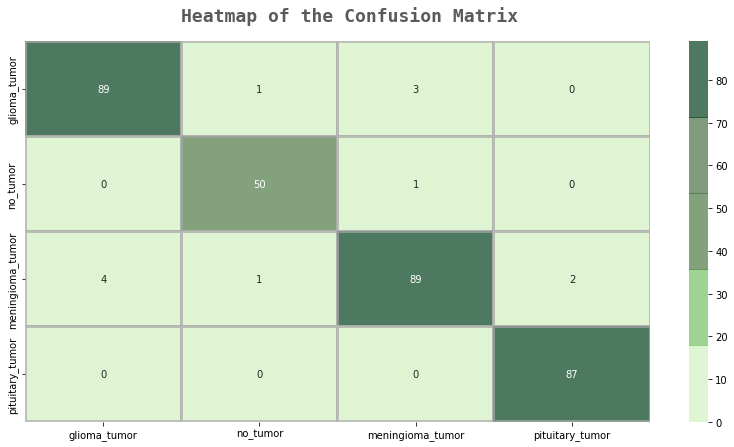

In [19]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

In [20]:
def tumor_type(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

---

In [21]:
binary_labels=['no','yes']

In [22]:
!unzip yes-no-brain-tumor2.zip

Archive:  yes-no-brain-tumor2.zip
replace yes-no-brain-tumor2/yes+no/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
X2 = []
y2 = []
image_size = 128
for w in binary_labels:
    folderPath2 = os.path.join(r'/content/yes-no-brain-tumor2','yes+no',w)
    for jj in tqdm(os.listdir(folderPath2)):
        img = cv2.imread(os.path.join(folderPath2,jj))
        img = cv2.resize(img,(image_size, image_size))
        X2.append(img)
        y2.append(w)

        
X2 = np.array(X2)
y2 = np.array(y2)

100%|██████████| 155/155 [00:00<00:00, 283.83it/s]


In [24]:

X2, y2= shuffle(X2,y2,random_state=101)

In [25]:
X2.shape

(253, 128, 128, 3)

In [26]:

datagen.fit(X2)
X2.shape

(253, 128, 128, 3)

In [27]:
X_train2, X_test2, y_train2,y_test22=train_test_split(X2,y2, test_size=0.1, random_state=101)

In [28]:
y_train__2 = []
for i in y_train2:
    y_train__2.append(binary_labels.index(i))
y_train2 = y_train__2
y_train2 = tf.keras.utils.to_categorical(y_train2)


y_test__2 = []
for i in y_test22:
    y_test__2.append(binary_labels.index(i))
y_test22 = y_test__2
y_test22 = tf.keras.utils.to_categorical(y_test22)

In [29]:
from tensorflow.keras.applications import ResNet50
binary_resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))


In [30]:
model2 = binary_resnet.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.2)(model2)
model2 = tf.keras.layers.Dense(2,activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=binary_resnet.input, outputs = model2)

In [31]:
X_train2.shape

(227, 128, 128, 3)

In [32]:
y_train2.shape

(227, 2)

In [33]:
model2.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [34]:
checkpoint2 = ModelCheckpoint('resnet50v1.h5',monitor="val_accuracy",save_best_only=True,mode="AUTO",verbose=1)

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=0.001)

In [35]:
history2 = model2.fit (X_train2,y_train2,validation_split=0.2, epochs =30, verbose=1, batch_size=32,
                      callbacks =[checkpoint2,reduce_lr2])

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7790
Epoch 00001: val_accuracy improved from -inf to 0.52174, saving model to resnet50v1.h5
6/6 [==============================] - 14s 1s/step - loss: 0.6379 - accuracy: 0.7790 - val_loss: 42.2189 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8177
Epoch 00002: val_accuracy did not improve from 0.52174
6/6 [==============================] - 2s 273ms/step - loss: 0.4688 - accuracy: 0.8177 - val_loss: 3452.0632 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8895
Epoch 00003: val_accuracy did not improve from 0.52174
6/6 [==============================] - 2s 275ms/step - loss: 0.4567 - accuracy: 0.8895 - val_loss: 44850.1758 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9503
Epo

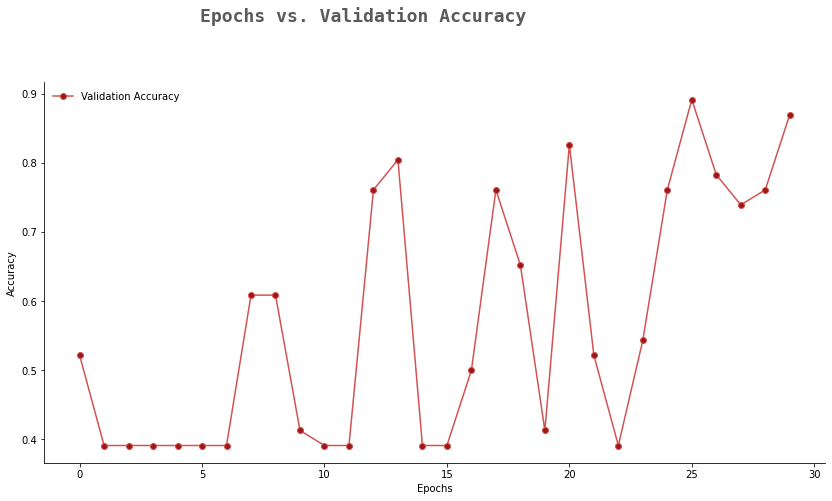

In [40]:
filterwarnings('ignore')

epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,1,figsize=(14,7))
val_acc = history2.history['val_accuracy']

fig.text(s='Epochs vs. Validation Accuracy',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()

ax.plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

fig.show()





In [41]:
pred2 = model2.predict(X_test2)
pred2 = np.argmax(pred2,axis=1)
y_test_la = np.argmax(y_test22,axis=1)

In [43]:
print(classification_report(y_test_la,pred2))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.88      0.94      0.91        16

    accuracy                           0.88        26
   macro avg       0.89      0.87      0.88        26
weighted avg       0.88      0.88      0.88        26



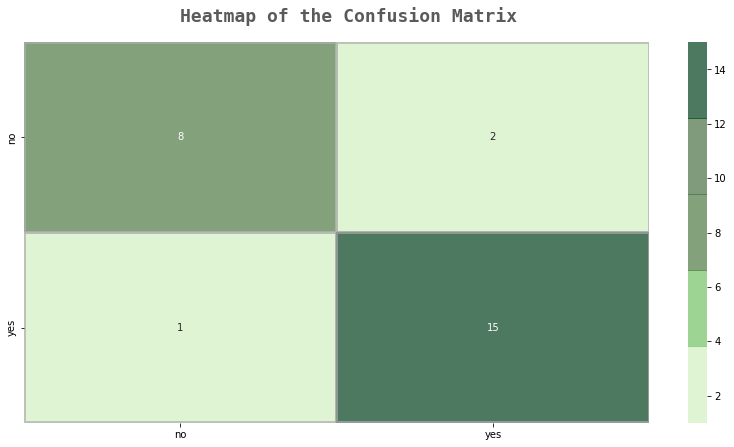

In [45]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test__2,pred2),ax=ax,xticklabels=binary_labels,yticklabels=binary_labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [44]:
def tumor_presence(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='No Tumor'
    elif p==1:
        print('Tumor present')
    else:
      print('unclassified')
    if p!=1:
        print(f'The Model predicts that it is a {p}')